In [14]:
#Imports
import nltk
import networkx as nx
import pandas as pd
import os
from nltk.corpus import PlaintextCorpusReader, stopwords
import os
import string
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from nltk.tokenize import word_tokenize

# Ensure that NLTK's resources are available
nltk.download('punkt')

# Read the CSV file
got_data = pd.read_csv("Game_of_Thrones_Script.csv", delimiter=';')

# Combine the sentences for each episode
grouped_data = got_data.groupby(['Season', 'Episode'])['Sentence'].apply(' '.join).reset_index()

# Tokenize the text for each episode
grouped_data['Tokenized Sentences'] = grouped_data['Sentence'].apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asger\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Function to remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Remove stopwords
grouped_data['Cleaned Tokens'] = grouped_data['Tokenized Sentences'].apply(remove_stopwords)

In [5]:
def parse_txt(filepath="pone.0026752.s001.txt"):
    word_data = {}
    with open(filepath, 'r') as file:
        next(file)  # skip the header
        for line in file:
            parts = line.split('\t')
            if len(parts) < 3:  # Ensure there are enough parts in the line
                continue
            word = parts[0]
            try:
                happiness_avg = float(parts[2])
                word_data[word] = happiness_avg
            except ValueError:  # Handle cases where the value isn't a float
                continue
    return word_data

word_data = parse_txt()

# Functions for sentiment analysis
def sentiment_score_per_file(tokens_dict, word_data):
    scores = {}
    for file_name, tokens in tokens_dict.items():
        scores[file_name] = sentiment_score(tokens, word_data)
    return scores

def sentiment_score(tokens, word_data):
    nominator = 0
    denominator = 0
    for token in tokens:
        if token not in word_data:
            continue
        else:
            frequency = tokens.count(token)
            nominator += (word_data[token]*frequency)
            denominator += frequency
    return nominator/denominator if denominator != 0 else 0

# Prepare data for sentiment analysis
tokens_dict = grouped_data.set_index(['Season', 'Episode'])['Cleaned Tokens'].to_dict()

# Calculate sentiment scores
episode_scores = sentiment_score_per_file(tokens_dict, word_data)

# Display sentiment scores
print(episode_scores)


{('Season 1', 'Episode 1'): 5.36409989122552, ('Season 1', 'Episode 10'): 5.335616222896313, ('Season 1', 'Episode 2'): 5.322585593823021, ('Season 1', 'Episode 3'): 5.320838154088872, ('Season 1', 'Episode 4'): 5.330167546336064, ('Season 1', 'Episode 5'): 5.401869913686801, ('Season 1', 'Episode 6'): 5.3818146820655715, ('Season 1', 'Episode 7'): 5.49347474747475, ('Season 1', 'Episode 8'): 5.519390635022454, ('Season 1', 'Episode 9'): 5.335709352275604, ('Season 2', 'Episode 1'): 5.4416006387347, ('Season 2', 'Episode 10'): 5.579943755858773, ('Season 2', 'Episode 2'): 5.375435114503784, ('Season 2', 'Episode 3'): 5.403187599364083, ('Season 2', 'Episode 4'): 5.476604530183168, ('Season 2', 'Episode 5'): 5.347080811298693, ('Season 2', 'Episode 6'): 5.470627126436778, ('Season 2', 'Episode 7'): 5.457759865423692, ('Season 2', 'Episode 8'): 5.353886843744674, ('Season 2', 'Episode 9'): 5.369143724257524, ('Season 3', 'Episode 1'): 5.408645926812239, ('Season 3', 'Episode 10'): 5.3153

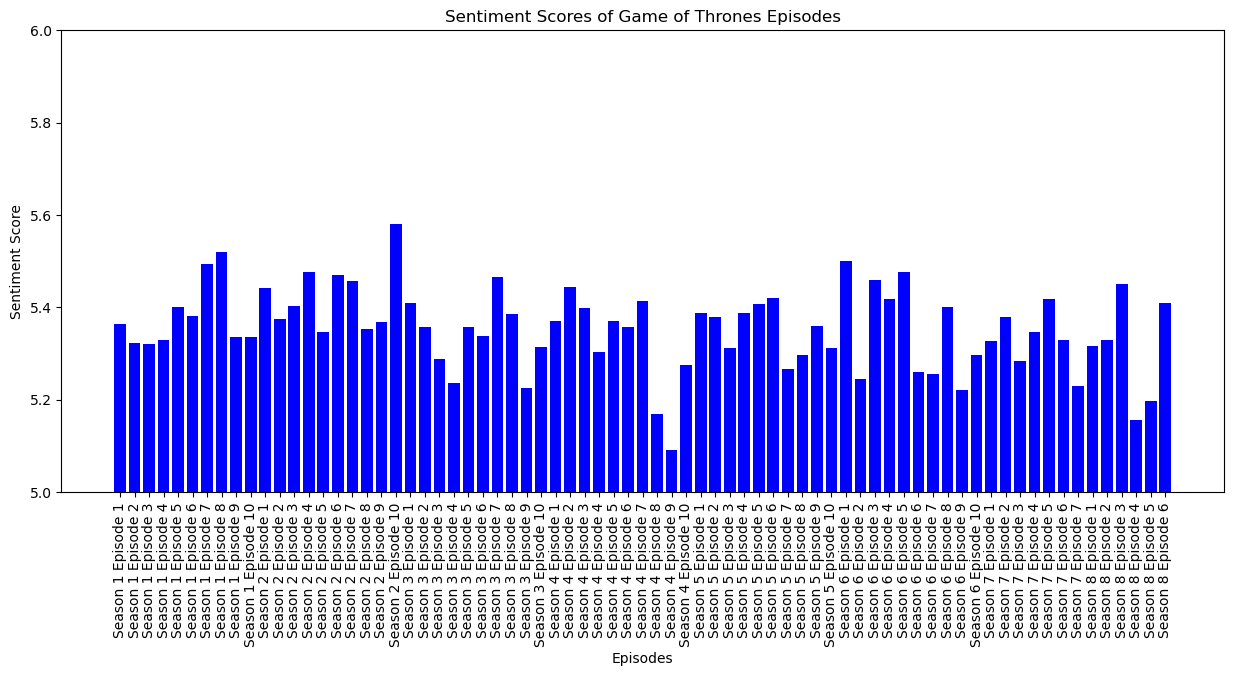

In [13]:
# Convert the dictionary to a DataFrame
episode_list = [f"{season} {episode}" for season, episode in episode_scores.keys()]
score_list = list(episode_scores.values())
score_df = pd.DataFrame({'Episode': episode_list, 'Score': score_list})

# Extract numerical parts for sorting
score_df['Season_Number'] = score_df['Episode'].apply(lambda x: int(x.split(' ')[1]))
score_df['Episode_Number'] = score_df['Episode'].apply(lambda x: int(x.split(' ')[3]))

# Sort by season and episode number
score_df.sort_values(by=['Season_Number', 'Episode_Number'], inplace=True)

# Plotting
plt.figure(figsize=(15, 6))
plt.bar(score_df['Episode'], score_df['Score'], color='blue')
plt.xlabel('Episodes')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores of Game of Thrones Episodes')
plt.xticks(rotation=90) # Rotates the x-axis labels for readability
plt.ylim(5, 6) # Set the y-axis limits
plt.show()

In [20]:
def permutation_test_episodes(df, episode, num_simulations=1000):
    # Extract the sentiment scores
    all_scores = df['Score'].to_numpy()
    target_score = df[df['Episode'] == episode]['Score'].mean()

    count_higher = 0
    count_lower = 0
    count_equal = 0

    for _ in range(num_simulations):
        np.random.shuffle(all_scores)  # Shuffle the scores
        shuffled_mean = np.mean(all_scores[:len(df[df['Episode'] == episode])])

        if shuffled_mean > target_score:
            count_higher += 1
        elif shuffled_mean < target_score:
            count_lower += 1
        else:
            count_equal += 1

    p_value = count_higher / num_simulations

    result = {
        "episode": episode,
        "shuffled_mean_higher": count_higher,
        "shuffled_mean_lower": count_lower,
        "shuffled_mean_equal": count_equal,
        "p_value": p_value
    }

    return result



In [21]:
# Loop through each episode and store results in a list
results = []
for episode in score_df['Episode'].unique():
    result = permutation_test_episodes(score_df, episode)
    results.append({
        "Episode": episode,
        "Is Statistically Significant": result['p_value'] < 0.05,
        "P-Value": result['p_value']
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df.style.apply(lambda x: ['background: lightgreen' if x['Is Statistically Significant'] else '' for _ in x], axis=1)

,Episode,Is Statistically Significant,P-Value
0,Season 1 Episode 1,False,0.230000
1,Season 1 Episode 2,False,0.369000
2,Season 1 Episode 3,False,0.172000
3,Season 1 Episode 4,False,0.957000
4,Season 1 Episode 5,False,0.644000
5,Season 1 Episode 6,False,0.415000
6,Season 1 Episode 7,False,0.104000
7,Season 1 Episode 8,False,0.886000
8,Season 1 Episode 9,False,0.445000
9,Season 1 Episode 10,False,0.302000


In [22]:
def sentiment_analysis(episode_scores, specific_episode_score, num_iterations=1000):
    all_scores = list(episode_scores.values())
    num_episodes = 1  # Since we are analyzing one episode at a time

    shuffled_means = []
    for _ in range(num_iterations):
        random_sample = np.random.choice(all_scores, size=num_episodes, replace=False)
        shuffled_means.append(np.mean(random_sample))

    count_lower = sum(1 for mean in shuffled_means if mean < specific_episode_score)
    count_higher = sum(1 for mean in shuffled_means if mean > specific_episode_score)

    proportion_lower = count_lower / num_iterations
    proportion_higher = count_higher / num_iterations

    if proportion_lower < 0.05:
        result = "Lower"
    elif proportion_higher < 0.05:
        result = "Higher"
    else:
        result = "Insignificant"

    return {
        'specific_episode_score': specific_episode_score,
        'proportion_lower': proportion_lower,
        'proportion_higher': proportion_higher,
        'result': result
    }

# Apply the function to each episode
analysis_results = {}
for episode, score in episode_scores.items():
    analysis_results[episode] = sentiment_analysis(episode_scores, score)


# Convert the results to a DataFrame
analysis_results_df = pd.DataFrame(analysis_results).transpose()

# Display the DataFrame
analysis_results_df.style.apply(lambda x: ['background: lightgreen' if x['result'] != 'Do not reject the null hypothesis.' else '' for _ in x], axis=1)

TypeError: unhashable type: 'numpy.ndarray'

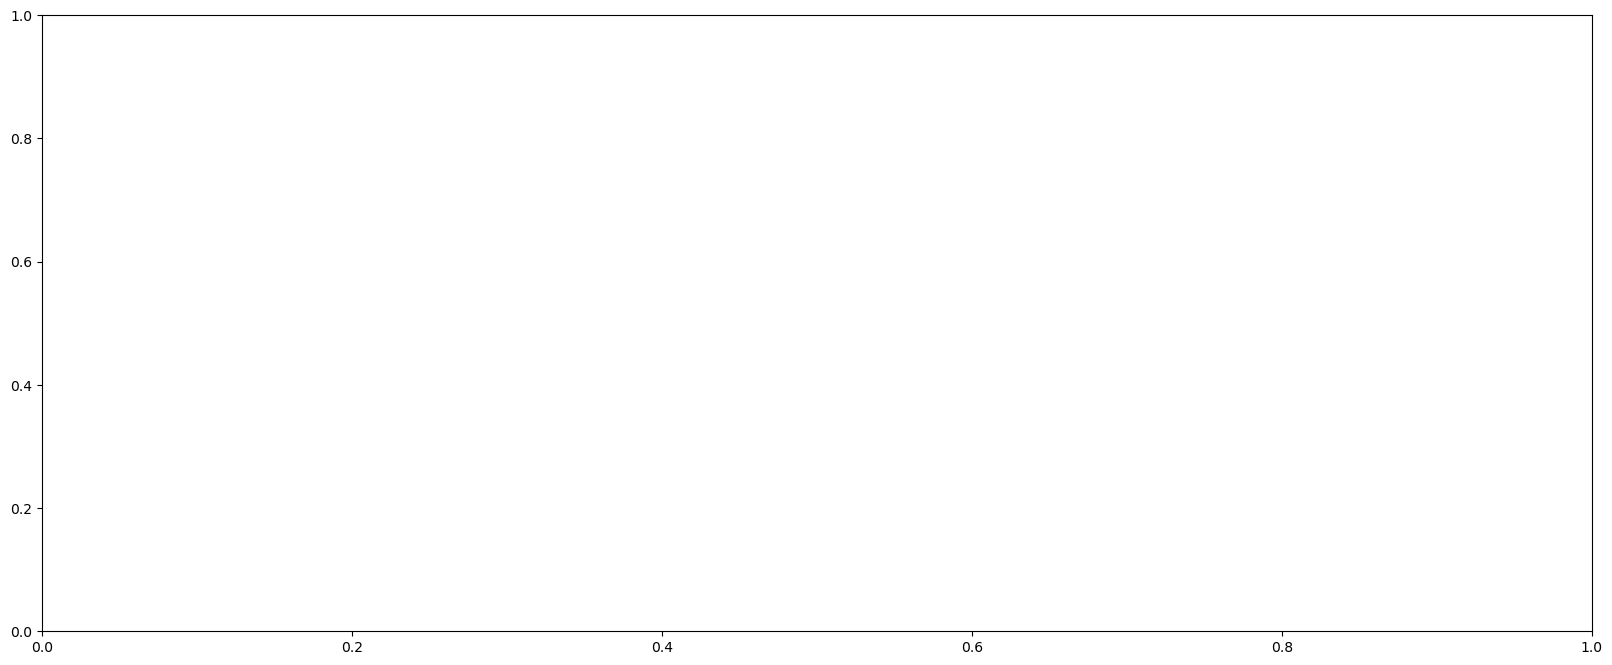

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Compute global thresholds
all_scores = list(episode_scores.values())
shuffled_means = []
for _ in range(1000):
    random_sample = np.random.choice(all_scores, size=len(all_scores), replace=False)
    shuffled_means.append(np.mean(random_sample))

lower_threshold = np.percentile(shuffled_means, 5)
upper_threshold = np.percentile(shuffled_means, 95)

# Determine significance of each episode
def determine_significance(score):
    if score < lower_threshold:
        return "Lower"
    elif score > upper_threshold:
        return "Higher"
    else:
        return "Insignificant"

# Apply the significance determination to each episode
significance_results = {episode: determine_significance(score) for episode, score in episode_scores.items()}

# Create the histogram
plt.figure(figsize=(15, 6))
for episode, score in episode_scores.items():
    color = 'red' if significance_results[episode] == "Lower" else ('green' if significance_results[episode] == "Higher" else 'blue')
    plt.bar(episode, score, color=color)

plt.axhline(y=lower_threshold, color='red', linestyle='--', label='Lower Significance Threshold')
plt.axhline(y=upper_threshold, color='green', linestyle='--', label='Upper Significance Threshold')

plt.xlabel('Episodes')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores of Game of Thrones Episodes with Significance Indicators')
plt.xticks(rotation=90)
plt.legend()
plt.show()
